# TP - Performances LoRaWAN

Ce TP est à réaliser après le mini projet. Nous vous demanderons un rapport ainsi que les courbes tracées grâce à ce TP.
Vous n'êtes pas obligés de faire tourner ce notebook sur la Raspberry Pi utilisée pendant le Mini Projet.

Dans ce TP, vous allez réaliser une étude sur le **Facteur d'Étalement** (*Spreading Factor* ou **SF**) de LoRaWAN.

Vous utiliserez le module LoRa Mote de microchip que vous avez déjà utilisé dans les TP précédents.
Ainsi, nous vous encourageons à réutiliser les fonctions développées dans le cadre du mini projet et à les importer ci-dessous.

Montrez dans votre étude que vous avez compris ce que vous faites, les commentaires sont encouragés.

Si vous n'arrivez pas à utiliser la bibliothèque Paho MQTT pour récupérer les trames, vous pouvez les récupérer manuellement et les enregistrer dans un fichier vous-mêmes.

## Ressources 

### RN2483
Documentation du module RN2483 :
https://ww1.microchip.com/downloads/en/DeviceDoc/RN2483-LoRa-Technology-Module-Command-Reference-User-Guide-DS40001784G.pdf

Ressources externes :
https://github.com/CampusIoT/tutorial/blob/master/rn2483/README.md

### Paho MQTT

Vous devrez utiliser la librairie Paho MQTT sous python afin de pouvoir vous **connecter au broker MQTT**, **subscribe au topic** et **enregistrer les trames**.

Documentation : https://pypi.org/project/paho-mqtt/  
Guide/Tutoriel : https://www.hivemq.com/blog/mqtt-client-library-paho-python/

### Seaborn

Afin de réaliser les courbes, nous vous proposons d'utiliser seaborn. Vous pouvez utiliser autre chose si vous le souhaitez, mais seaborn est une bibliothèque assez simple d'utilisation et haut niveau.

Documentation : https://seaborn.pydata.org/

### JSON

Les trames récupérées via MQTT sont dans le format JSON. Vous pouvez utiliser la bibliothèque json pour travailler avec ce format.   

Documentation : https://docs.python.org/3/library/json.html  
Tutoriel simple : https://opensource.com/article/19/7/save-and-load-data-python-json

#### /!\ Attention /!\
Si vous décidez d'utiliser la Raspberry Pi, voici les solutions à certains problèmes rencontrés par vos camarades durant le projet :

* Impossible de se connecter au jupyter notebook => Quand ça arrive, je recrée un venv : `python3 -m venv venv2`. N'oubliez pas de modifier la ligne `include-system-site-packages = false` en `include-system-site-packages = true` dans le fichier `venv2/pyenv.cfg` avant de le sourcer.
* Pour éviter un temps de téléchargement trop long quand vous essayez d'installer des paquets, mettez la Raspberry Pi à l'heure à l'aide de :  
`sudo date --set 'YYYY-MM-DD HH:mm:ss' `

# Import et installation

In [18]:
#Import serial
try:
  import serial
except:
  !pip install pyserial
  import serial

In [19]:
#Import Paho mqtt
try:
  import paho.mqtt.client as paho
except:
  %pip install paho-mqtt
  import paho.mqtt.client as paho

In [20]:
#Import seaborn
try:
  import seaborn as sns
except:
  !pip install seaborn
  import seaborn as sns

In [21]:
#Import json
import json
import time
import logging

## Exemple seaborn

     total_bill   tip     sex smoker   day    time  size
0         16.99  1.01  Female     No   Sun  Dinner     2
1         10.34  1.66    Male     No   Sun  Dinner     3
2         21.01  3.50    Male     No   Sun  Dinner     3
3         23.68  3.31    Male     No   Sun  Dinner     2
4         24.59  3.61  Female     No   Sun  Dinner     4
..          ...   ...     ...    ...   ...     ...   ...
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

[244 rows x 7 columns]


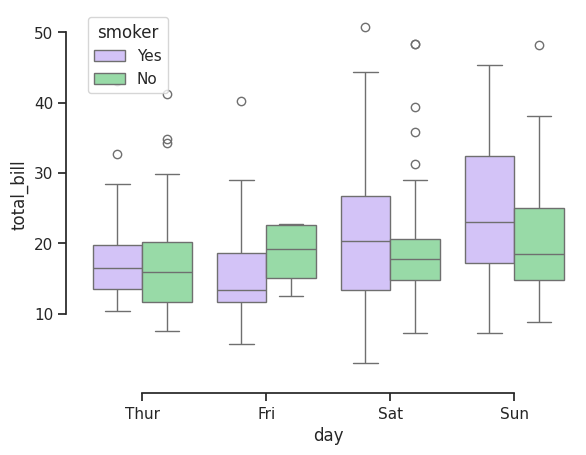

In [22]:
sns.set_theme(style="ticks", palette="pastel")

# Load the example tips dataset
tips = sns.load_dataset("tips")
print(tips)

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="day", y="total_bill",
            hue="smoker", palette=["m", "g"],
            data=tips)
sns.despine(offset=10, trim=True)

# Questions préliminaires

**Qu'est-ce que le SF ?**

Le SF (Spreading Factor) est un paramètre dans les réseaux LoRaWAN, il définit la durée de transmission d'un paquet de données sur un canal donné. Il influence directement la portée du signal et la consommation énergétique, tout en affectant le débit de données. Il va de 7 à 12.

**Qu'est-ce que le RSSI ? Quelle est son unité ? Pourquoi est-ce important dans ce TP ?**

Le RSSI (Received Signal Strength Indicator) est un indicateur de la puissance du signal reçu par un dispositif. Il mesure la force du signal radio capté par un récepteur et est exprimé en dBm (décibels milliwatts). Plus le RSSI est élevé, plus le signal est fort.
Le RSSI permet d'évaluer la qualité de la connexion entre un appareil et la passerelle.

**Qu'est-ce que le SNR ? Quelle est son unité ? Pourquoi est-ce important dans ce TP ?**

Le SNR (Signal-to-Noise Ratio), ou rapport signal sur bruit en français, est une mesure de la qualité d'un signal par rapport au bruit de fond. Il évalue la proportion entre l'intensité du signal utile et celle du bruit qui peut interférer avec ce signal. Plus le SNR est élevé, plus le signal est clair et moins il y a d'interférence.

# Partie 1 : Récupération de trames.
Dans cette partie, récupérez une trentaine de trames LoRaWAN pour chaque SF. Enregistrez les dans un fichier pour pouvoir les réutiliser dans la partie 2.


Rappel :  
Le LoRa Network Server (ou LNS) est configuré pour publier les messages reçus vers le topic : 
`TestTopic/lora/{appid}/{deveui}/{event}`  
A l'aide de mosquitto_sub, vous allez **subscribe** à ce topic depuis une console grâce à la commande suivante :  
`mosquitto_sub -h neocampus.univ-tlse3.fr -t TestTopic/lora/{appid}/{deveui}/# -p 1882 -u test -P test`

Le broker MQTT neOCampus utilise le port 1882. En général, les brokers MQTT utilisent le port 1883. On précise le broker grâce à l'argument `-p` dans la commande ci dessus. 
**Si vous essayez d'accéder au broker depuis un réseau externe à l'université, il faudra utiliser le port 10882**

# Partie 2 : Analyse 
Dans cette partie, vous allez réutiliser les trames enregistrées lors de la partie 1.  
Quand vous traitez les trames, intéressez vous aux valeurs de la **best_gateway**.  

Si le résultat que vous obtenez n'est pas celui auquel vous vous attendiez, essayez de justifier pourquoi.

## RSSI

**Selon vous,quel comportement est attendu du RSSI quand on fait varier le SF ?**

On attend un RSSI qui croît avec le niveau de spreading factor (sf). 

**Tracez un graphe *(boxplot)* du RSSI en fonction du SF.**

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_1939/3351057762.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_combined, y="RSSI", x="SF", palette="Set2")
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


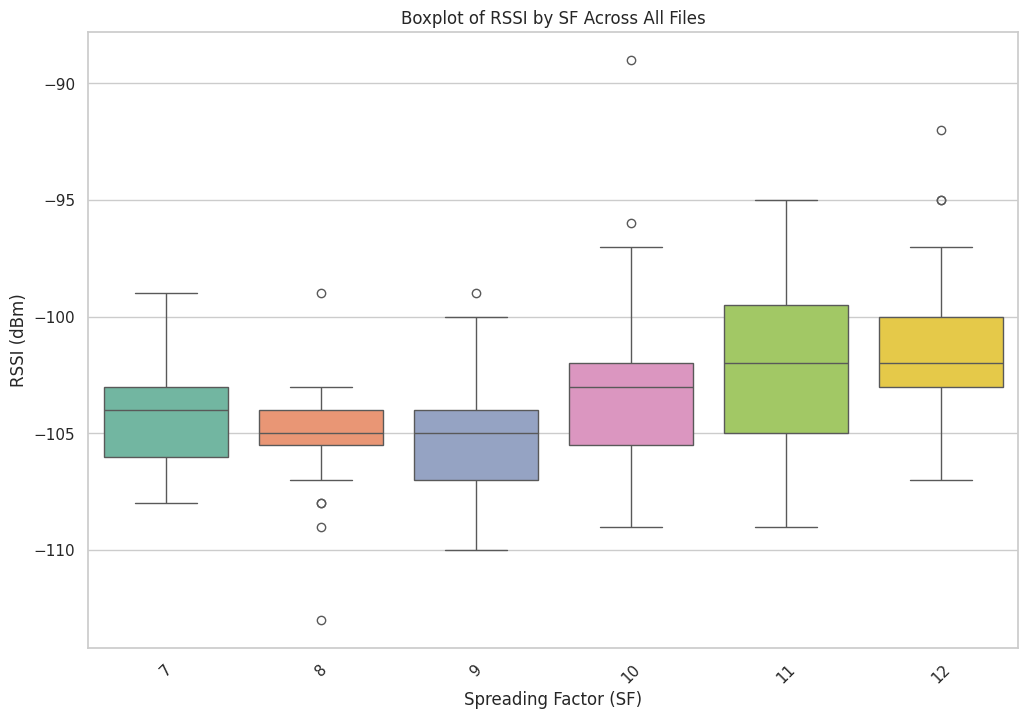

In [52]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Liste des fichiers json contenant les trames réçues
file_paths = [
    'json_file/tp_json_sf0.json',
    'json_file/tp_json_sf1.json',
    'json_file/tp_json_sf2.json',
    'json_file/tp_json_sf3.json',
    'json_file/tp_json_sf4.json',
    'json_file/tp_json_sf5.json',
]

# Lire et extraire les données des fichiers
all_data = []
for path in file_paths:
    with open(path, 'r') as file:
        data = json.load(file)
        for record in data:
            best_gw = record.get("best_gw", {})
            rssi = best_gw.get("rssi")
            datr = record.get("datr")
            # Parse the SF (Spreading Factor) from datr
            if datr.startswith("SF")and datr[2:4].isdigit():
                sf = int(datr[2:4])  #extraire la valeur de SF(e.g., "SF12BW125" -> 12)
                all_data.append({"RSSI": rssi, "SF": sf})
            else:
                sf = int(datr[2:3])
                all_data.append({"RSSI": rssi, "SF": sf})

# Création du DataFrame depuis nos données
df_combined = pd.DataFrame(all_data)
#print(df_combined)
# Afficher le boxplot du RSSI en fonction du SF
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_combined, y="RSSI", x="SF", palette="Set2")
plt.title("Boxplot of RSSI by SF Across All Files")
plt.suptitle("")  
plt.xlabel("Spreading Factor (SF)")
plt.ylabel("RSSI (dBm)")
plt.xticks(rotation=45)
plt.show()


**Commentez le graphe. Que pouvez vous conclure ? Est-ce ce à quoi vous vous attendiez ? Pourquoi ?**

Variation des valeurs RSSI en fonction du SF :
Les valeurs RSSI (indiquées en dBm) montrent une certaine variabilité pour chaque Spreading Factor (SF).

Le RSSI pour les différents SF semblent légèrement croître à mesure que le SF augmente. Ce qui était attendu cependant la difference entre les sf parait bien plus faible que ce qu'on avait imaginé. 

Cela est du au fait que l'on n'observe les resultats de la best gateway donc on ne prend les resultats des gateway les plus proches dans la plupart des cas. Donnant des resultats stables même en variant le sf.  

## SNR

**Selon vous,quel comportement est attendu du SNR quand on fait varier le SF ?**

Plus on a un spreading factor grand, plus le SNR va diminuer. Car un SF grand implique une resistantes au interferences.

**Tracez un graphe *(boxplot)* du SNR en fonction du SF.**

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_1939/2341221529.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_combined, y="LSNR", x="SF", palette="Set2")
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


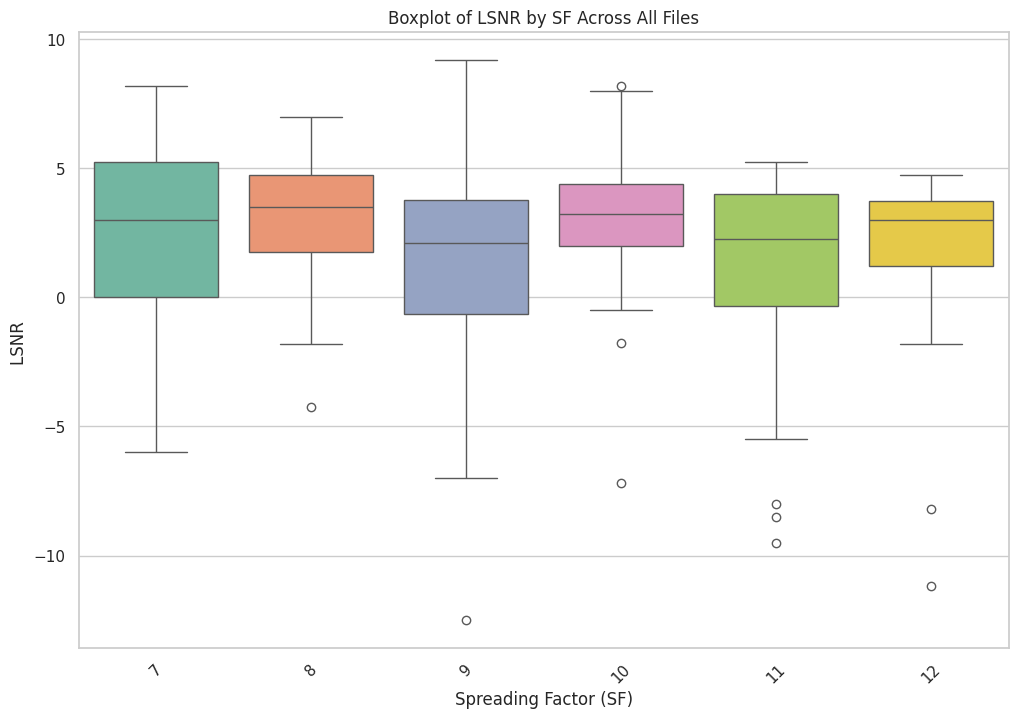

In [47]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# List of file paths for the JSON files
file_paths = [
    'json_file/tp_json_sf0.json',
    'json_file/tp_json_sf1.json',
    'json_file/tp_json_sf2.json',
    'json_file/tp_json_sf3.json',
    'json_file/tp_json_sf4.json',
    'json_file/tp_json_sf5.json',
]

# Load and extract data from each file
all_data = []
for path in file_paths:
    with open(path, 'r') as file:
        data = json.load(file)
        for record in data:
            best_gw = record.get("best_gw", {})
            lsnr = best_gw.get("lsnr")
            datr = record.get("datr")
            # Parse the SF (Spreading Factor) from datr
            if datr.startswith("SF")and datr[2:4].isdigit():
                sf = int(datr[2:4])  # Extract SF value (e.g., "SF12BW125" -> 12)
                all_data.append({"LSNR": lsnr, "SF": sf})
            else:
                sf = int(datr[2:3])
                all_data.append({"LSNR": lsnr, "SF": sf})

# Create a DataFrame from the extracted data
df_combined = pd.DataFrame(all_data)
#print(df_combined)
# Plot the boxplot of RSSI values by SF
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_combined, y="LSNR", x="SF", palette="Set2")
plt.title("Boxplot of LSNR by SF Across All Files")
plt.suptitle("")  # Suppress the default title
plt.xlabel("Spreading Factor (SF)")
plt.ylabel("LSNR ")
plt.xticks(rotation=45)
plt.show()


**Commentez le graphe. Que pouvez vous conclure ? Est-ce ce à quoi vous vous attendiez ? Pourquoi ?**

Les résultats démontre que le LSNR ne varie pas comme prévu en fonction des sf. Cela est du au fait que l'on n'observe les resultats de la best gateway donc on ne prend les resultats des gateway les plus proches dans la plupart des cas. Donnant des resultats stables même en variant le sf. 

## Data Extraction Rate de chaque gateway pour chaque SF
Dans cette partie, on vous demande le % de messages captés par chaque gateway pour chaque SF.

**Selon vous, que va entrainer la modification du SF ? Quel SF utiliser pour maximiser le DER ?**

L'augmentation du sf va permettre au gw lointaine de mieux capter notre message, donc cela va dépendre, si on souhaite une transmission rapide des données avec une extraction de donnée exécuté de manière optimale sur une gw proche on prefera un sf bas. Si on prefere un bon repartissement des données sur toutes les gw il faudrait alors mieux privilégier un sf grand. 

**Tracez un graphe *(boxplot)* du DER de chaque gateway en fonction du SF.**

In [49]:
import json


# Liste des chemins vers les fichiers JSON
file_paths = [
    'json_file/tp_json_sf0.json',
    'json_file/tp_json_sf1.json',
    'json_file/tp_json_sf2.json',
    'json_file/tp_json_sf3.json',
    'json_file/tp_json_sf4.json',
    'json_file/tp_json_sf5.json',
]

# Charger et extraire les données de chaque fichier
all_data = []
for path in file_paths:
    with open(path, 'r') as file:
        data = json.load(file)
        for record in data:
            all_gw = record.get("all_gw", [])  # Liste des gateways captant le message
            datr = record.get("datr")  # Facteur d'étalement (SF)
            if datr.startswith("SF") and datr[2:4].isdigit():
                sf = int(datr[2:4])  # Extraire le SF (par exemple, "SF12BW125" -> 12)
                for gw in all_gw:
                    gateway_desc = gw.get("desc", "Unknown")  # Description de la gateway
                    all_data.append({"SF": sf, "Gateway": gateway_desc})
            else:
                sf = int(datr[2:3])  # Extraire le SF (par exemple, "SF12BW125" -> 12)
                for gw in all_gw:
                    gateway_desc = gw.get("desc", "Unknown")  # Description de la gateway
                    all_data.append({"SF": sf, "Gateway": gateway_desc})
               


# Créer un DataFrame à partir des données extraites
df = pd.DataFrame(all_data)

# Vérifier les données extraites
print("Aperçu des données :")
print(df.head())
# Calculer le nombre total de messages captés par chaque gateway pour chaque SF
message_counts = df.groupby(["SF", "Gateway"]).size().reset_index(name="MessageCount")
print(message_counts)


Aperçu des données :
   SF                                            Gateway
0  12  Mikrotik LtAP LR8 (Jean-Louis Druilhe) @IRIT2-366
1  12               MTCDTIP-266A / LoRa gateway @ Ecolab
2  12         [eCOnect] Jetson nano + PyGate @ IRIT2-460
3  12            MTCDT-210A / LoRa gateway @ BU sciences
4  12  Mikrotik LtAP LR8 (Jean-Louis Druilhe) @IRIT2-366
    SF                                            Gateway  MessageCount
0    7               MTCDT-210A / LoRa gateway @ BU santé            14
1    7            MTCDT-210A / LoRa gateway @ BU sciences            19
2    7               MTCDTIP-266A / LoRa gateway @ Ecolab            21
3    7  Mikrotik LtAP LR8 (Jean-Louis Druilhe) @IRIT2-366            30
4    7         [eCOnect] Jetson nano + PyGate @ IRIT2-460            33
5    8               MTCDT-210A / LoRa gateway @ BU santé            19
6    8            MTCDT-210A / LoRa gateway @ BU sciences            22
7    8               MTCDTIP-266A / LoRa gateway @ Ecolab    

In [51]:
# Ajouter un pourcentage des messages captés pour chaque SF
total_messages_per_sf = message_counts.groupby("SF")["MessageCount"].transform("sum")
message_counts["Percentage"] = (message_counts["MessageCount"] / total_messages_per_sf) * 100

# Afficher les résultats finaux
print("Pourcentage des messages captés par chaque gateway pour chaque SF :")
print(message_counts["Percentage"])

Pourcentage des messages captés par chaque gateway pour chaque SF :
0     11.965812
1     16.239316
2     17.948718
3     25.641026
4     28.205128
5     15.447154
6     17.886179
7     19.512195
8     24.390244
9     22.764228
10    13.559322
11    16.949153
12    16.949153
13    26.271186
14    26.271186
15    14.864865
16    19.594595
17    22.297297
18    21.621622
19    21.621622
20    16.260163
21    16.260163
22    19.512195
23    22.764228
24    25.203252
25     7.826087
26    11.304348
27    25.217391
28    27.826087
29    27.826087
Name: Percentage, dtype: float64


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


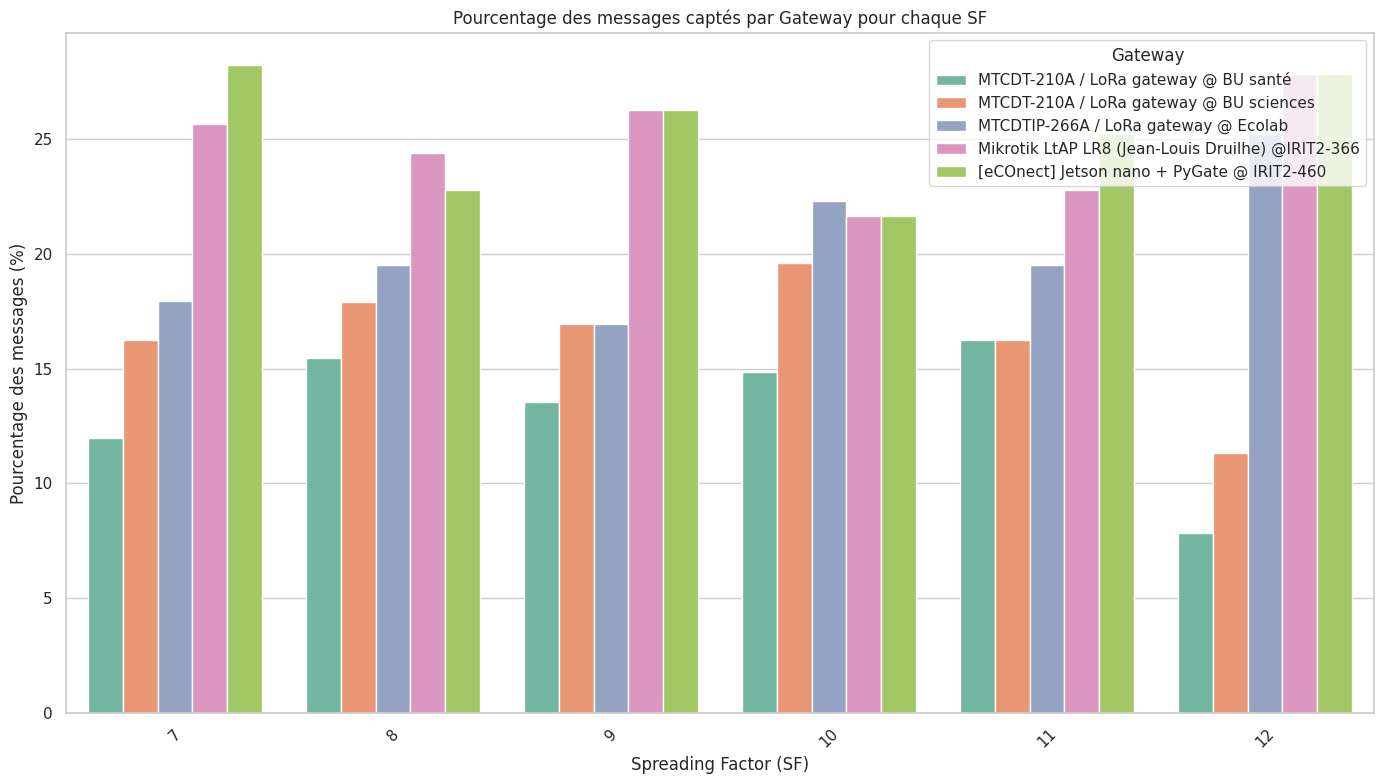

In [33]:
# Visualisation avec Seaborn (Grouped Barplot)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 8))

sns.barplot(
    data=message_counts,
    x="SF",          # Axe X : SF
    y="Percentage",  # Axe Y : Pourcentage des messages
    hue="Gateway",   # Groupement par Gateway
    palette="Set2"   # Palette des couleurs
)

# Ajustements esthétiques
plt.title("Pourcentage des messages captés par Gateway pour chaque SF")
plt.xlabel("Spreading Factor (SF)")
plt.ylabel("Pourcentage des messages (%)")
plt.legend(title="Gateway", loc="upper right")
plt.xticks(rotation=45)
plt.tight_layout()

# Afficher le graphique
plt.show()

**Commentez le graphe. Que pouvez vous conclure ? Est-ce ce à quoi vous vous attendiez ? Pourquoi ?**

On observe qu'en utilisant un sf bas ou haut les gw proches seront meilleurs. Pour une bonne que les gw lointaine soit meilleur un sf moyen semble mieux. 

# Distance

Le lien ci-dessous permet de voir où sont situées les gateways.  
**A quelle distance étiez vous des gateways quand vous émettiez ?**

https://www.google.com/maps/d/u/0/edit?mid=1oBEwKLwUyCBqnEczIpG0BARMm9NM1a0&usp=sharing 


- MTCDTIP-266A / LoRa gateway @ Ecolab : 500m
- [eCOnect] Jetson nano + PyGate @ IRIT2-4600 : 5m
- MTCDT-210A / LoRa gateway @ BU sciences : 380m
- Mikrotik LtAP LR8 (Jean-Louis Druilhe) @IRIT2-366 : 150m
- MTCDT-210A / LoRa gateway @ BU santé : 1200km

**La distance joue-t-elle un rôle sur le RSSI et le SNR ? Expliquez.**

Pour les gateways proches (<1km) l'impact est minime. Mais comme on peut le voir le dernier graph la distances jouent beaucoup sur la reception des données. 

**La distance joue-t-elle un rôle dans le choix du SF ? Que pouvez vous en conclure ?**

Les messages envoyé avec un haut sf seront plus facile à décoder que les messages envoyé avec un sf bas d'où l'interêt d'utiliser un sf haut. Mais comme vu sur nos shémas il peut être mieux de choisir un sf plus optimisé en fonction de notre environement.

**En plus du SF, pouvez vous citer d'autres paramètres importants afin d'optimiser les transmissions LoRaWAN ?**

On peut optimiser en :
- Choissisant un canal de frequence loraWAN non utilisé
- En augmentant le nombre de packet envoyé (bandwith)
- La taille des packets envoyés (en les encodants etc)
- Utilisation de ADR (adaptive Data rate) pour augmenter la puissance d'envoi
